In [127]:
import pandas as pd
import numpy as np
import yaml
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from scipy.fft import fft
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import openpyxl
import plotly.graph_objects as go

In [44]:
def load_yaml(file):
    import yaml
    with open(file, 'r') as f:
        config = yaml.safe_load(f)
    return config
    



In [45]:
config = load_yaml('../config.yaml')

In [46]:
trading_data = pd.read_excel(config['data_excel_path'], sheet_name='Data')
print(trading_data.head())

                 Date     Open      High       Low    Close  Volume  \
0 2024-12-02 12:30:00  603.490  603.6700  603.4000  603.605  173717   
1 2024-12-02 12:35:00  603.610  603.7584  603.5210  603.610  113154   
2 2024-12-02 12:40:00  603.585  603.7500  603.5450  603.720   78513   
3 2024-12-02 12:45:00  603.720  603.8050  603.6700  603.740   62266   
4 2024-12-02 12:50:00  603.745  603.8200  603.6852  603.765   44356   

       BOLLBU      BOLLBM      BOLLBL   DONUP  ...       EMA20       PVPTR  \
0  604.211450  603.461755  602.712060  603.96  ...  603.529738  603.828333   
1  604.172164  603.507255  602.842346  603.96  ...  603.537382  603.867200   
2  604.073775  603.565205  603.056635  603.96  ...  603.554774  603.876667   
3  604.078234  603.591705  603.105176  603.96  ...  603.572415  603.873333   
4  604.078241  603.619460  603.160679  603.96  ...  603.590756  603.891533   

         PVPT       PVPTS   TCHRE    ADWM    ADWMMA      WASI     VOLMA  \
0  603.558333  603.288333  59

In [47]:
trading_data['DayofWeek'] = trading_data['Date'].dt.dayofweek

print(trading_data.tail())

                    Date      Open    High       Low   Close  Volume  \
5811 2025-01-17 19:35:00  597.5800  597.62  597.5700  597.58    1279   
5812 2025-01-17 19:40:00  597.6000  597.62  597.5990  597.60    1144   
5813 2025-01-17 19:45:00  597.6200  597.62  597.6200  597.62     164   
5814 2025-01-17 19:50:00  597.6000  597.62  597.6000  597.61     943   
5815 2025-01-17 19:55:00  597.6583  597.70  597.6583  597.69    5085   

          BOLLBU      BOLLBM      BOLLBL   DONUP  ...       PVPTR        PVPT  \
5811  597.652919  597.545495  597.438071  597.69  ...  597.640000  597.590000   
5812  597.657005  597.551495  597.445985  597.69  ...  597.627333  597.606333   
5813  597.660195  597.559495  597.458795  597.69  ...  597.620000  597.620000   
5814  597.665276  597.563995  597.462714  597.69  ...  597.630000  597.610000   
5815  597.685438  597.572500  597.459562  597.70  ...  597.724467  597.682767   

           PVPTS   TCHRE     ADWM     ADWMMA      WASI   VOLMA   ADJATR  \
5811 

In [48]:
trading_data['Take_Profit_Level'] = trading_data['Close'] + (trading_data['Close'] * config['atr_multiplier'] * trading_data['ADJATR'])
print(trading_data.head())

                 Date     Open      High       Low    Close  Volume  \
0 2024-12-02 12:30:00  603.490  603.6700  603.4000  603.605  173717   
1 2024-12-02 12:35:00  603.610  603.7584  603.5210  603.610  113154   
2 2024-12-02 12:40:00  603.585  603.7500  603.5450  603.720   78513   
3 2024-12-02 12:45:00  603.720  603.8050  603.6700  603.740   62266   
4 2024-12-02 12:50:00  603.745  603.8200  603.6852  603.765   44356   

       BOLLBU      BOLLBM      BOLLBL   DONUP  ...        PVPT       PVPTS  \
0  604.211450  603.461755  602.712060  603.96  ...  603.558333  603.288333   
1  604.172164  603.507255  602.842346  603.96  ...  603.629800  603.392400   
2  604.073775  603.565205  603.056635  603.96  ...  603.671667  603.466667   
3  604.078234  603.591705  603.105176  603.96  ...  603.738333  603.603333   
4  604.078241  603.619460  603.160679  603.96  ...  603.756733  603.621933   

    TCHRE    ADWM    ADWMMA      WASI     VOLMA   ADJATR  DayofWeek  \
0  598.96  3.3084  3.185521 -9.20

In [49]:
def calculate_label(data):
    data['Label'] = 'H'
    for i in range(len(data)):
        stop_loss_level = data['Close'][i] - ((data['Take_Profit_Level'][i] - data['Close'][i]) * config['risk'])
        for j in range(1, config['bars_no_to_wait']):
            if i+j < len(data):
                if data['High'][i+j] >= data['Take_Profit_Level'][i]:
                    data.iloc[i, data.columns.get_loc('Label')] = 'B'
                    break
                elif data['Low'][i+j] < stop_loss_level:
                    data.iloc[i, data.columns.get_loc('Label')] = 'S'
                    break
    return data

In [50]:
trading_data = calculate_label(trading_data)

In [51]:
trading_data.value_counts('Label')

Label
H    4652
S     964
B     200
Name: count, dtype: int64

In [52]:
trading_data['Date'] = pd.to_datetime(trading_data['Date'])
fig = go.Figure(data=[go.Candlestick(x=trading_data['Date'], open=trading_data['Open'], high=trading_data['High'], low=trading_data['Low'], close=trading_data['Close'])])
fig.update_layout(title='CandleStick Chart SPY', xaxis_title='Date', yaxis_title='Price', xaxis_rangeslider_visible=False, yaxis=dict(fixedrange=False), xaxis=dict(type='category'))
buy_signals = trading_data[trading_data['Label'] == 'B']
sell_signals = trading_data[trading_data['Label'] == 'S']
fig.add_trace(go.Scatter(x=buy_signals['Date'], y=buy_signals['Low'], mode='markers', name='Buy Signal', marker=dict(color='blue', size=10)))
fig.add_trace(go.Scatter(x=sell_signals['Date'], y=sell_signals['High'], mode='markers', name='Sell Signal', marker=dict(color='yellow', size=10)))
fig.show()

In [61]:
def compute_fourier_transform(data, n_components=10):
    fft_values = fft(data)
    fft_real = np.real(fft_values[:n_components])
    fft_imag = np.imag(fft_values[:n_components])
    fft_mag = np.abs(fft_values[:n_components])
    #print("Hello")
    return np.hstack([fft_real, fft_imag, fft_mag])


In [140]:
def get_features(data):
    fourier_lookback_window = config['fourier_lookback_window']
    fourier_n_components = config['fourier_n_components']
    # need to use min max scaler for g1
    raw_features_g1 = config['raw_features_g1'].split(',')
    print(raw_features_g1)

    #g2 is the other features. need to use standard scaler for this
    raw_features_g2 = config['raw_features_g2'].split(',')

    #g3 is volume features. need to use min max scaler separately
    raw_features_g3 = config['raw_features_g3'].split(',')

    #print(data[raw_features_g1].head())
    #print(data[raw_features_g1].dtypes)
    global_min_g1 = data[raw_features_g1].min().min()
    global_max_g1 = data[raw_features_g1].max().max()

    #Apply min max scaler to g1
    if (global_max_g1 - global_min_g1) == 0:
        print("Divide by 0 coming")
    data[raw_features_g1] = (data[raw_features_g1] - global_min_g1) / (global_max_g1 - global_min_g1)

    # Apply standard scaler to g2
    print("Before standard scaler")
    scaler = StandardScaler()
    data[raw_features_g2] = scaler.fit_transform(data[raw_features_g2])
    print("After standard scaler")

    
    eps = 1e-5
    data[raw_features_g3] = np.log(data[raw_features_g3] + eps)

    # Apply min max scaler to g3
    global_min_g3 = data[raw_features_g3].min().min()
    global_max_g3 = data[raw_features_g3].max().max()
    if (global_max_g3 - global_min_g3) == 0:
        print("2 Divide by 0 coming")
        
    data[raw_features_g3] = (data[raw_features_g3] - global_min_g3) / (global_max_g3 - global_min_g3)

    # Add one hot encoding for dayofweek column
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', categories=[range(7)])
    encoded_days = encoder.fit_transform(data[['DayofWeek']])
    encoded_days_df = pd.DataFrame(encoded_days, columns=[f'Day_{i}' for i in range(7)])
    data = pd.concat([data, encoded_days_df], axis=1)
    features = []
    epsilon = 1e-5
    for end in range( fourier_lookback_window, len(data)+1, 1):
        #print(f"end is : {end}")
        close_window = data['Close'].iloc[end-fourier_lookback_window:end].values

        #volume_window = data['Volume'].iloc[end-fourier_lookback_window:end].values

        # Calculate percentage changes for the Close values in the window
        pct_close_window = ((close_window - close_window[0]) / close_window[0])
        #log_volume_window = np.log(volume_window + epsilon)
        #pct_volume_window = np.diff(log_volume_window) * 100
        fourier_close_features = compute_fourier_transform(pct_close_window, n_components=fourier_n_components)
        fourier_min = fourier_close_features.min()
        fourier_max = fourier_close_features.max()
        fourier_close_features = (fourier_close_features - fourier_min) / (fourier_max - fourier_min)
        #fourier_volume_features = compute_fourier_transform(pct_volume_window, n_components=fourier_n_components)

        raw_features_g1_df = data[raw_features_g1].iloc[end-1].values
        raw_features_g2_df = data[raw_features_g2].iloc[end-1].values
        raw_features_g3_df = data[raw_features_g3].iloc[end-1].values

        day_of_week_df = data[[f'Day_{i}' for i in range(7)]].iloc[end-1].values

        #combine all features
        combined_features = np.hstack([fourier_close_features, raw_features_g1_df, raw_features_g2_df, raw_features_g3_df, day_of_week_df])
        features.append(combined_features)

    close_columns = [f'Close_FFT_Real_{i}' for i in range(fourier_n_components)] + \
    [f'Close_FFT_Imag_{i}' for i in range(fourier_n_components)] + \
    [f'Close_FFT_Mag_{i}' for i in range(fourier_n_components)]

    volume_columns = [f'Volume_FFT_Real_{i}' for i in range(fourier_n_components)] + \
    [f'Volume_FFT_Imag_{i}' for i in range(fourier_n_components)] + \
    [f'Volume_FFT_Mag_{i}' for i in range(fourier_n_components)]


    feature_columns = close_columns + raw_features_g1 + raw_features_g2 + raw_features_g3 + [f'Day_{i}' for i in range(7)]
    df_features = pd.DataFrame(features, columns=feature_columns)
    output_excel_path = '../temp_data/input_features.xlsx'
    df_features.to_excel(output_excel_path, index=False)


    features = np.array(features)
    return features

In [141]:
#raw_features_g1
trading_features = get_features(trading_data)

['Open', 'High', 'Low', 'Close', 'BOLLBU', 'BOLLBM', 'BOLLBL', 'DONUP', 'DONMID', 'DONLOW', 'MA20', 'MA50', 'MA100', 'EMA20', 'PVPTR', 'PVPT', 'PVPTS', 'TCHRE']
Before standard scaler
After standard scaler


In [142]:
print(trading_features.shape)

(5717, 61)


In [144]:
dbscan = DBSCAN(eps=2, min_samples=10, n_jobs=1)
dbscan_labels = dbscan.fit_predict(trading_features)

# Add labels to the features for visualization
features_with_labels = np.hstack([trading_features, dbscan_labels.reshape(-1, 1)])
print(np.unique(dbscan_labels))

[-1  0  1]


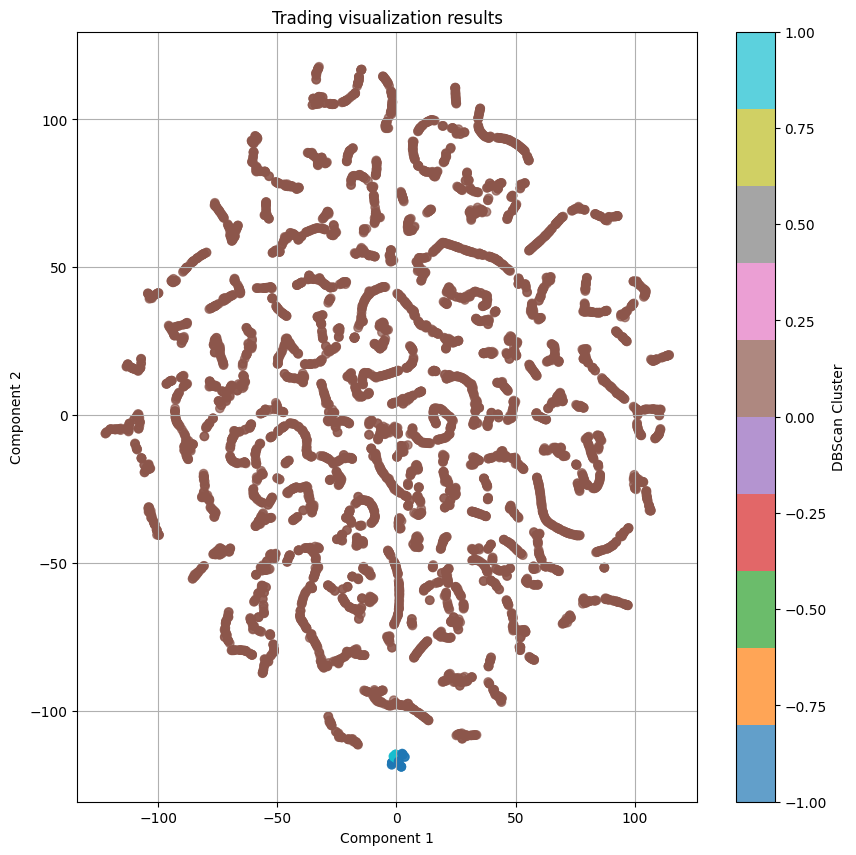

In [145]:
tsne = TSNE(n_components=2, perplexity=10, learning_rate=200)
tsne_results = tsne.fit_transform(trading_features)

# Add tsne results to the features for visualization
plt.figure(figsize=(10, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=dbscan_labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='DBScan Cluster')
plt.title("Trading visualization results")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid()
plt.show()


In [125]:
f_lookback = config['fourier_lookback_window']

In [130]:
trading_data.iloc[f_lookback:]['Label'].value_counts()

Label
H    4552
S     964
B     200
Name: count, dtype: int64

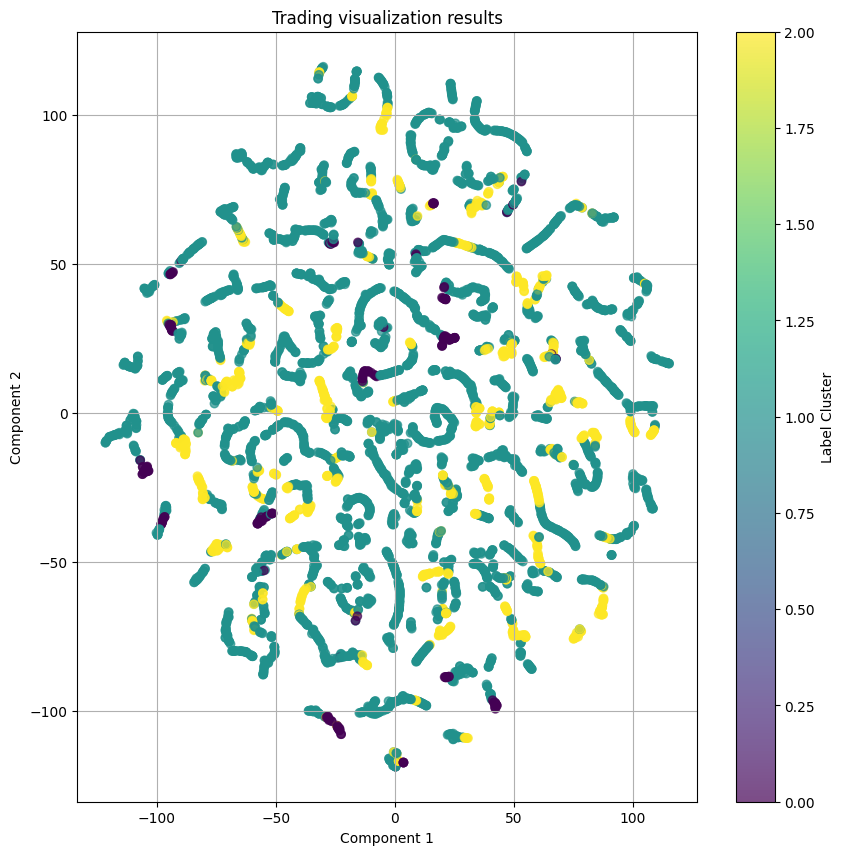

In [146]:
labels_cat = trading_data.iloc[f_lookback-1:]['Label'].values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_cat)
tsne = TSNE(n_components=2, perplexity=10, learning_rate=200)
tsne_results = tsne.fit_transform(trading_features)

# Add tsne results to the features for visualization
plt.figure(figsize=(10, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels_encoded, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Label Cluster')
plt.title("Trading visualization results")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid()
plt.show()
